ecmwf-opendata and eccodes packages from EC need to be installed. 

An extra directory level has been introduced in the path to the ECMWF data files which breaks client.py (and possibly other scripts). client.py is unable to locate data files as a result after 28th Feb 2024.
The new structure is:
https://data.ecmwf.int/forecasts/20240228/06z/ifs/
or
https://data.ecmwf.int/forecasts/20240228/06z/aifs/

As a quick fix, assuming you want to use IFS data, you can modify the value of HOURLY_PATTERN in the client.py file, i.e.

HOURLY_PATTERN = (
    "{_url}/{_yyyymmdd}/{_H}z/ifs/{resol}/{_stream}/"
    "{_yyyymmddHHMMSS}-{step}h-{_stream}-{type}.{_extension}"
)



In [1]:
from ecmwf.opendata import Client
import collections
import sys
import traceback
import glob, os
from eccodes import *
import numpy as np

give the date and time interested, and download the EC tc-ensemble data and save as TC_ensemble_current.bufr

In [12]:
date=20240314     #  query the server for the most recent matching data when date and time are missing
time=0           #  query the server for the most recent matching data when date and time are missing

In [ ]:

client = Client(source="ecmwf")

# The Client.latest() method takes the same parameters as the Client.retrieve() method, and returns the date of the most recent matching forecast without downloading the data
# NOTE: The data is available between 7 and 9 hours after the forecast starting date and time, depending on the forecasting system and the time step specified. so may got error if the data is not ready

# print(client.latest(
#     stream="enfo",
#     type="tf",
#     step=144,
#     target="TC_ensemble_current.bufr",
# ))

if time == 0 or time == 12:
    step=240 
else:
    step=144
    
result = client.retrieve(
    date=date,     #  query the server for the most recent matching data when date and time are missing
    time=time,           #  query the server for the most recent matching data when date and time are missing
    stream="enfo",
    type="tf",
    step=step,         #  For time=06 and 18, step = 144, while for time=00 and 12, step = 240
    target="TC_ensemble_current.bufr",
)
print(result.datetime)

print the potentile TCs we are interested around Australia, and got the TC indentifier in EC models according to the lon and lat location

In [22]:
INPUT = "TC_ensemble_current.bufr"

VERBOSE = 1  # verbose error reporting
data = collections.defaultdict(dict)

# open BUFR file
f = open(INPUT, "rb")

cnt = 0
# loop for the messages in the file
while 1:
    # get handle for message
    bufr = codes_bufr_new_from_file(f)
    if bufr is None:
        break

    # we need to instruct ecCodes to expand all the descriptors
    # i.e. unpack the data values
    codes_set(bufr, "unpack", 1)

    stormIdentifier = codes_get(bufr, "stormIdentifier")
    
    latitudeMaxWind0 = codes_get_array(bufr, "#3#latitude")
    longitudeMaxWind0 = codes_get_array(bufr, "#3#longitude")
    
    if(max(latitudeMaxWind0) >= -40 and max(latitudeMaxWind0) <= 0 and max(longitudeMaxWind0) >= 90 and max(longitudeMaxWind0) <= 180):
        print("**************** MESSAGE: ", cnt + 1, "  *****************")
        print("Storm identifier: ", stormIdentifier)
        print("latitudeMaxWind0: ", max(latitudeMaxWind0))
        print("longitudeMaxWind0: ", max(longitudeMaxWind0))

    cnt += 1

    # release the BUFR message
    codes_release(bufr)

# close the file
f.close()

**************** MESSAGE:  2   *****************
Storm identifier:  18S
latitudeMaxWind0:  -14.8
longitudeMaxWind0:  116.3
**************** MESSAGE:  15   *****************
Storm identifier:  70U
latitudeMaxWind0:  -3.8000000000000003
longitudeMaxWind0:  134.5
**************** MESSAGE:  16   *****************
Storm identifier:  71U
latitudeMaxWind0:  -8.9
longitudeMaxWind0:  153.1
**************** MESSAGE:  17   *****************
Storm identifier:  72U
latitudeMaxWind0:  -7.1000000000000005
longitudeMaxWind0:  154.4
**************** MESSAGE:  18   *****************
Storm identifier:  73U
latitudeMaxWind0:  -12.700000000000001
longitudeMaxWind0:  156.70000000000002
**************** MESSAGE:  22   *****************
Storm identifier:  70P
latitudeMaxWind0:  -15.700000000000001
longitudeMaxWind0:  179.70000000000002
**************** MESSAGE:  23   *****************
Storm identifier:  71P
latitudeMaxWind0:  -21.0
longitudeMaxWind0:  179.5


In [23]:
# step 2: according to the TC indentifier got from last step, select the TC you are interested
storm_case = "18S"  

print track intensity forecast to csv file for all members in EC

In [25]:
# open BUFR file
f = open(INPUT, "rb")

cnt = 0

# loop for the messages in the file
while 1:
    # get handle for message
    bufr = codes_bufr_new_from_file(f)
    if bufr is None:
        break

    # we need to instruct ecCodes to expand all the descriptors
    # i.e. unpack the data values
    codes_set(bufr, "unpack", 1)

    numObs = codes_get(bufr, "numberOfSubsets")
    year = codes_get(bufr, "year")
    month = codes_get(bufr, "month")
    day = codes_get(bufr, "day")
    hour = codes_get(bufr, "hour")
    minute = codes_get(bufr, "minute")

    # print("type of year: ", type(year))
    # print("Number of observations: ", numObs)

    stormIdentifier = codes_get(bufr, "stormIdentifier")

    
    if storm_case == stormIdentifier:
        print("**************** MESSAGE: ", cnt + 1, "  *****************")
        print("Date and time: ", day, ".", month, ".", year, "  ", hour, ":", minute)
        print("Storm identifier: ", stormIdentifier)
        
        # How many different timePeriod in the data structure?
        numberOfPeriods = 0
        while True:
            numberOfPeriods = numberOfPeriods + 1
            try:
                codes_get_array(bufr, "#%d#timePeriod" % numberOfPeriods)
            except CodesInternalError as err:
                break
                # the numberOfPeriods includes the analysis (period=0)

        # Get ensembleMemberNumber
        memberNumber = codes_get_array(bufr, "ensembleMemberNumber")
        memberNumberLen = len(memberNumber)
        print("Number of ensemble members: ", len(memberNumber))
        print("Ensemble member ID: ", memberNumber)

        # Observed Storm Centre
        significance = codes_get(bufr, "#1#meteorologicalAttributeSignificance")
        latitudeCentre = codes_get(bufr, "#1#latitude")
        longitudeCentre = codes_get(bufr, "#1#longitude")

        if significance != 1:
            print("ERROR: unexpected #1#meteorologicalAttributeSignificance")

        if (latitudeCentre == CODES_MISSING_DOUBLE) and (
            longitudeCentre == CODES_MISSING_DOUBLE
        ):
            print("Observed storm centre position missing")
        else:
            print(
                "Observed storm centre: latitude=",
                latitudeCentre,
                " longitude=",
                longitudeCentre,
            )

        # Location of storm in perturbed analysis
        significance = codes_get_array(bufr, "#2#meteorologicalAttributeSignificance")

        if significance[0] != 4:
            print("ERROR: unexpected #2#meteorologicalAttributeSignificance")

        latitudeAnalysis = codes_get_array(bufr, "#2#latitude")
        longitudeAnalysis = codes_get_array(bufr, "#2#longitude")
        if len(longitudeAnalysis) == 1:
            longitudeAnalysis = np.repeat(longitudeAnalysis[0], len(latitudeAnalysis))
        pressureAnalysis = codes_get_array(bufr, "#1#pressureReducedToMeanSeaLevel")
        # print("latitudeAnalysis: ", latitudeAnalysis)
        # print("longitudeAnalysis: ", longitudeAnalysis)
        # print("pressureAnalysis: ", pressureAnalysis)

        # Location of Maximum Wind
        significance = codes_get_array(bufr, "#3#meteorologicalAttributeSignificance")

        if significance[0] != 3:
            print(
                "ERROR: unexpected #3#meteorologicalAttributeSignificance=",
                significance,
            )

        latitudeMaxWind0 = codes_get_array(bufr, "#3#latitude")
        longitudeMaxWind0 = codes_get_array(bufr, "#3#longitude")
        windMaxWind0 = codes_get_array(bufr, "#1#windSpeedAt10M")
        # print("latitudeMaxWind0: ", latitudeMaxWind0)
        # print("longitudeMaxWind0: ", longitudeMaxWind0)
        # print("windMaxWind0: ", windMaxWind0)

        if len(latitudeAnalysis) == len(memberNumber) and len(latitudeMaxWind0) == len(
            memberNumber
        ):
            for k in range(len(memberNumber)):
                data[k][0] = [
                    latitudeAnalysis[k],
                    longitudeAnalysis[k],
                    pressureAnalysis[k],
                    latitudeMaxWind0[k],
                    longitudeMaxWind0[k],
                    windMaxWind0[k],
                ]

        else:
            for k in range(len(memberNumber)):
                data[k][0] = [
                    latitudeAnalysis[0],
                    longitudeAnalysis[0],
                    pressureAnalysis[0],
                    latitudeMaxWind0[0],
                    longitudeMaxWind0[0],
                    windMaxWind0[0],
                ]

        timePeriod = [0 for x in range(numberOfPeriods)]
        for i in range(1, numberOfPeriods):
            rank1 = i * 2 + 2
            rank3 = i * 2 + 3

            ivalues = codes_get_array(bufr, "#%d#timePeriod" % i)

            if len(ivalues) == 1:
                timePeriod[i] = ivalues[0]
            else:
                for j in range(len(ivalues)):
                    if ivalues[j] != CODES_MISSING_LONG:
                        timePeriod[i] = ivalues[j]
                        break

            # Location of the storm
            values = codes_get_array(
                bufr, "#%d#meteorologicalAttributeSignificance" % rank1
            )
            if len(values) == 1:
                significance = values[0]
            else:
                for j in range(len(values)):
                    if values[j] != CODES_MISSING_LONG:
                        significance = values[j]
                        break

            if significance == 1:
                lat = codes_get_array(bufr, "#%d#latitude" % rank1)
                lon = codes_get_array(bufr, "#%d#longitude" % rank1)
                press = codes_get_array(
                    bufr, "#%d#pressureReducedToMeanSeaLevel" % (i + 1)
                )
            else:
                print(
                    "ERROR: unexpected meteorologicalAttributeSignificance=",
                    significance,
                )

            # Location of maximum wind
            values = codes_get_array(
                bufr, "#%d#meteorologicalAttributeSignificance" % rank3
            )
            if len(values) == 1:
                significanceWind = values[0]
            else:
                for j in range(len(values)):
                    if values[j] != CODES_MISSING_LONG:
                        significanceWind = values[j]
                        break

            if significanceWind == 3:
                latWind = codes_get_array(bufr, "#%d#latitude" % rank3)
                lonWind = codes_get_array(bufr, "#%d#longitude" % rank3)
                wind10m = codes_get_array(bufr, "#%d#windSpeedAt10M" % (i + 1))
            else:
                print(
                    "ERROR: unexpected meteorologicalAttributeSignificance=",
                    significanceWind,
                )
            
            # print("number of member: ", len(memberNumber))
            # print("memberNumber: ", memberNumber)
            # print("number of lat: ", len(lat))
            # print("lat: ", lat)
            # print("lon: ", lon)
            # print("press: ", press)
            # print("latWind: ", latWind)
            # print("lonWind: ", lonWind)
            # print("wind10m: ", wind10m)
            for k in range(len(lat)):
                # print("k: ", k)
                # print("memberNumber: ", memberNumber)
                data[k][i] = [
                    lat[k],
                    lon[k],
                    press[k],
                    latWind[k],
                    lonWind[k],
                    wind10m[k],
                ]

        # ---------------------------------------- Print the values -------------
        for f in glob.glob(storm_case + '_Member_*.csv'):
            os.remove(f)
        for m in range(len(memberNumber)):
            TXTFILE_output = storm_case + '_Member_' + str(m+1) + '.csv'
            txtfile = open(TXTFILE_output,"w")  
            txtfile.write("step,lat_p,lon_p,pressure,lat_w,lon_w,wind \n")
            print("== Member  %d" % memberNumber[m])
            print("step  latitude  longitude   pressure  latitude   longitude    wind")
            for s in range(len(timePeriod)):
                if (
                    data[m][s][0] != CODES_MISSING_DOUBLE
                    and data[m][s][1] != CODES_MISSING_DOUBLE
                ):
                    print(
                        " {0:>3d}{1}{2:>6.1f}{3}{4:>6.1f}{5}{6:>8.1f}{7}{8:>6.1f}{9}{10:>6.1f}{11}{12:>6.1f}".format(
                            timePeriod[s],
                            "  ",
                            data[m][s][0],
                            "     ",
                            data[m][s][1],
                            "     ",
                            data[m][s][2],
                            "  ",
                            data[m][s][3],
                            "     ",
                            data[m][s][4],
                            "     ",
                            data[m][s][5],
                        )
                    )
                    
                    txtfile.write(str(timePeriod[s]) + "," + str(data[m][s][0]) + "," + str(data[m][s][1]) + "," + str(data[m][s][2]) + "," + str(data[m][s][3]) + "," + str(data[m][s][4]) + "," + str(data[m][s][5]) + "\n") 

            txtfile.close()    
        # -----------------------------------------------------------------------
        
    cnt += 1

    # release the BUFR message
    codes_release(bufr)

# close the file
f.close()

**************** MESSAGE:  2   *****************
Date and time:  14 . 3 . 2024    12 : 0
Storm identifier:  18S
Number of ensemble members:  52
Ensemble member ID:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52]
Observed storm centre: latitude= -16.9  longitude= 115.4
== Member  1
step  latitude  longitude   pressure  latitude   longitude    wind
   0   -17.0      115.2      99800.0   -16.1      115.5       21.6
   6   -17.4      115.0      99800.0   -15.8      115.2       18.0
  12   -17.5      114.3      99800.0   -15.7      113.1       15.4
  18   -17.7      115.1      99700.0   -13.6      114.5       14.4
  24   -17.8      114.9      99900.0   -17.4      113.1       12.9
  30   -18.1      115.1      99900.0   -17.0      114.5       12.4
  42   -18.2      113.3      99900.0   -15.3      111.7       13.4
  48   -18.6      112.7     100000.0   -15.3      111.5       12.9
  

In [4]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import pandas as pd
import glob, os
import numpy as np

plot all EC member tracks and their mean track, output the mean track to csv file

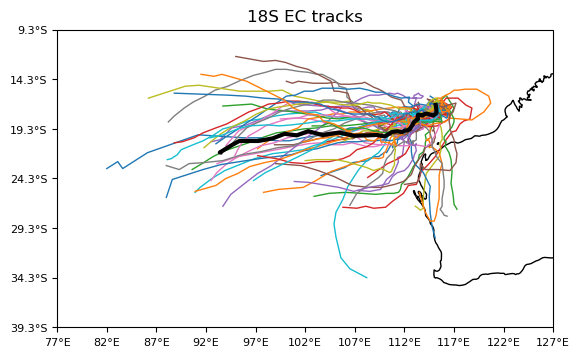

In [11]:
ax = plt.axes(projection=ccrs.PlateCarree())
storm_temp = []
for f in glob.glob(storm_case + '_Member_*.csv'):
    storm = pd.read_csv(f)
    p = ax.plot(storm.lon_p, storm.lat_p, linewidth=1,transform=ccrs.PlateCarree())
    storm_temp.append(storm)

storm = pd.concat(storm_temp, ignore_index=True)
temp = storm.groupby('step').mean()
temp.to_csv(storm_case + '_mean.csv') 
p2 = ax.plot(temp.lon_p, temp.lat_p, 'k-', linewidth=3, transform=ccrs.PlateCarree())

ax.tick_params(labelsize=8)
ax.set_title(storm_case + " EC tracks")
ax.coastlines()
ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
ax.yaxis.set_major_formatter(LatitudeFormatter())
ax.set_xticks(np.arange(storm.lon_p.min()-5, storm.lon_p.max()+7, 5), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(storm.lat_p.min()-5, storm.lat_p.max()+7, 5), crs=ccrs.PlateCarree())
fig_out = storm_case + '-EC-forecast-tracks.png'
plt.savefig(fig_out)
plt.show()


